In [49]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
from linearmodels.panel import PanelOLS
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
mpl.style.use('seaborn')

In [3]:
# Import data for income group categorization
low_inc = pd.read_csv('low_inc.csv')
lower_mid_inc = pd.read_csv('lower_mid_inc.csv')
upper_mid_inc = pd.read_csv('upper_mid_inc.csv')
high_inc = pd.read_csv('high_inc.csv')

low_inc=low_inc['Country Name'].tolist()[:-5] + ['low_inc']
lower_mid_inc = lower_mid_inc['Country Name'].tolist()[:-5] + ['lower_mid_inc']
upper_mid_inc = upper_mid_inc['Country Name'].tolist()[:-5] + ['upper_mid_inc']
high_inc = high_inc['Country Name'].tolist()[:-5] + ['high_inc']

In [4]:
# Cleaning and reshaping ICT data
ICT = pd.read_csv('/Users/chenruoyu/Desktop/DB project data/ICT.csv')

ICT=ICT.rename(columns={'2004 [YR2004]':2004,'2005 [YR2005]':2005,'2006 [YR2006]':2006,'2007 [YR2007]':2007,'2008 [YR2008]':2008,\
                        '2009 [YR2009]':2009,'2010 [YR2010]':2010,'2011 [YR2011]':2011,'2012 [YR2012]':2012,\
                        '2013 [YR2013]':2013,'2014 [YR2014]':2014,'2015 [YR2015]':2015,\
                        '2016 [YR2016]':2016,'2017 [YR2017]':2017,'2018 [YR2018]':2018})
    
for i in ICT.columns[4:]:
    ICT[i]=pd.to_numeric(ICT[i],errors='coerce')
    
ICT.drop(['Country Code','Series Code'],axis=1, inplace=True)
ICT.drop(ICT.index[-195:],inplace=True)

In [5]:
ICT.set_index(['Country Name', 'Series Name'],inplace=True)
ICT.columns.rename('year',inplace=True)
ICT=ICT.stack().swaplevel(1,2).unstack()

In [6]:
ICT=ICT.dropna()
ICT['Secure Internet servers (per 1 million people)']=np.log(ICT['Secure Internet servers (per 1 million people)']+1)

In [7]:
for i in [low_inc, lower_mid_inc, upper_mid_inc, high_inc]:
    ICT.loc[ICT.index.get_level_values('Country Name').isin(i),'inc_group']=i[-1]

In [8]:
# Cleaning and reshaping governance indicators data
WGI = pd.read_csv('/Users/chenruoyu/Desktop/DB project data/WGI2.csv')

WGI=WGI.rename(columns={'2004 [YR2004]':2004,'2005 [YR2005]':2005,'2006 [YR2006]':2006,'2007 [YR2007]':2007,'2008 [YR2008]':2008,
                        '2009 [YR2009]':2009,'2010 [YR2010]':2010,'2011 [YR2011]':2011,'2012 [YR2012]':2012,
                        '2013 [YR2013]':2013,'2014 [YR2014]':2014,'2015 [YR2015]':2015,
                        '2016 [YR2016]':2016,'2017 [YR2017]':2017,'2018 [YR2018]':2018})
for i in WGI.columns[4:]:
    WGI[i]=pd.to_numeric(WGI[i],errors='coerce')

WGI=WGI.drop(['Country Code','Series Code'],axis=1)
WGI=WGI.set_index(['Country Name','Series Name'])
WGI.columns.rename('year',inplace=True)
WGI=WGI.stack().swaplevel(1,2).unstack()

In [9]:
# Merging ICT and WGI data
ICT.index.rename(['country_name','time'],inplace=True)
WGI_ICT=WGI.merge(ICT, how='left', left_index=True, right_on=['country_name','time'])
WGI_ICT = WGI_ICT.swaplevel(0,1)

In [10]:
# New dataframe for the cleaned data
df=WGI_ICT.dropna()

In [11]:
df=df.rename(columns={'Control of Corruption: Estimate':'corruption','Government Effectiveness: Estimate':'effectiveness',
                  'Political Stability and Absence of Violence/Terrorism: Estimate':'stability','Regulatory Quality: Estimate':'regulation',
                  'Rule of Law: Estimate':'law','Voice and Accountability: Estimate':'voice','Fixed broadband subscriptions (per 100 people)':'broadband',
                  'ICT service exports (BoP, current US$)':'export','Individuals using the Internet (% of population)':'user',
                  'Mobile cellular subscriptions (per 100 people)':'mobile','Secure Internet servers (per 1 million people)':'server'})

In [12]:
df

,Series Name,corruption,effectiveness,stability,regulation,law,voice,broadband,user,mobile,server,inc_group
time,country_name,,,,,,,,,,,
2010,Afghanistan,-1.635723,-1.454683,-2.579152,-1.532861,-1.845436,-1.404468,0.005140,4.000000,35.003127,0.391833,low_inc
2012,Afghanistan,-1.419888,-1.360140,-2.418561,-1.193118,-1.643165,-1.267430,0.004814,5.454545,49.227977,0.797263,low_inc
2013,Afghanistan,-1.436761,-1.384930,-2.519349,-1.193137,-1.597314,-1.240068,0.004648,5.900000,52.083576,0.886034,low_inc
2014,Afghanistan,-1.354784,-1.331396,-2.411068,-1.118182,-1.445648,-1.135445,0.004495,7.000000,55.159515,0.996240,low_inc
2015,Afghanistan,-1.341994,-1.322968,-2.571222,-0.997371,-1.504040,-1.117563,0.020535,8.260000,57.271068,1.147502,low_inc
...,...,...,...,...,...,...,...,...,...,...,...,...
2014,Zambia,-0.342243,-0.499575,0.156212,-0.503428,-0.236549,-0.109601,0.133255,19.000000,65.681859,1.627469,lower_mid_inc
2015,Zambia,-0.341261,-0.555665,0.151695,-0.436516,-0.229715,-0.066545,0.147298,21.000000,72.784572,1.897280,lower_mid_inc
2016,Zambia,-0.401866,-0.660059,0.142808,-0.483593,-0.300440,-0.306110,0.194238,25.506579,73.438230,2.288606,lower_mid_inc


# Correlation visualization

As the first step to explore relationships between ICT development and governance, we plot scatterplots of all four ICT development indicators against all six dimensions of governance scores. Strong positive relationships between many variables are visible from the scatterplots, though for the scores on stability/absence of violence and voice and accountability, variations within the governance score are more pronounced. Another issue shown by the scatterplots that is worth noticing involves the effect of income groups. Higher income countries tend to have better ICT development and higher governance scores, which warns against endogeneity within any relationship between ICT variables and governance scores. Therefore, a natural next-step is to conduct regression analysis where income can be actively controlled for.

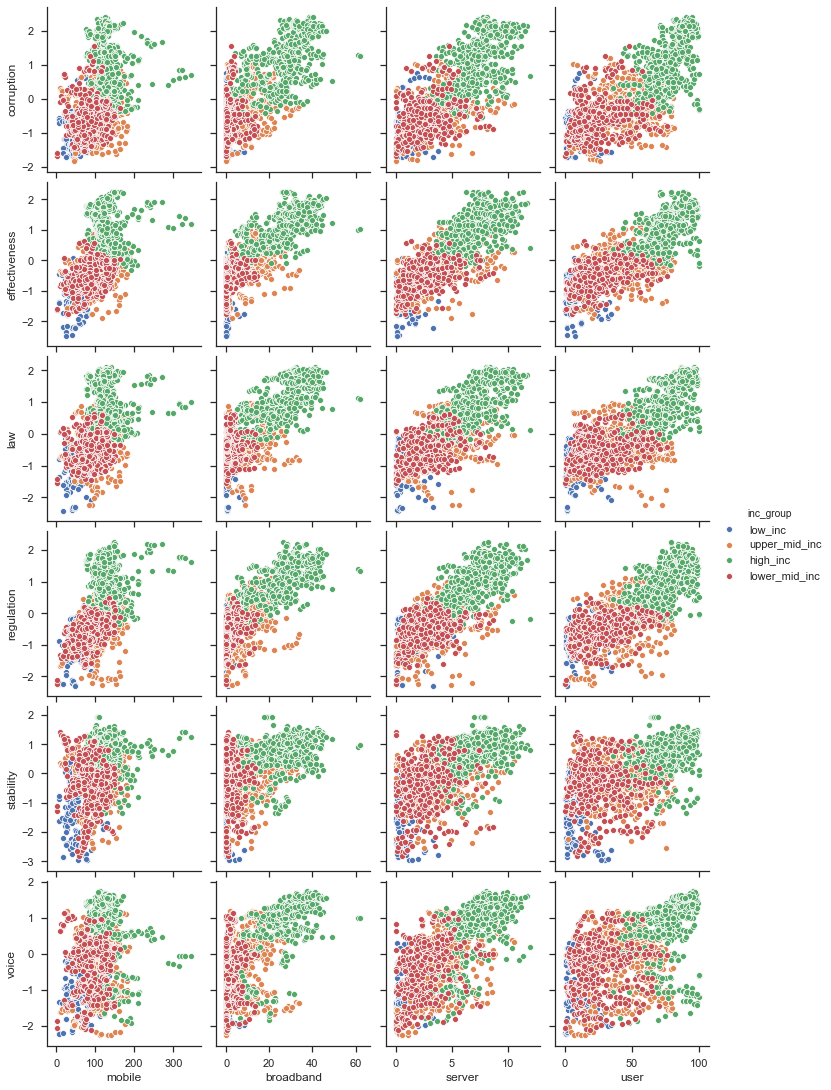

In [44]:
sns.set(style="ticks")
sns.pairplot(df, x_vars=['mobile','broadband','server','user'],
             y_vars = ['corruption','effectiveness', 'law', 'regulation', 'stability', 'voice'],
            hue="inc_group")


In [13]:
# Importing, cleaning and shaping control variable data
controls = pd.read_csv('/Users/chenruoyu/Desktop/DB project data/controls.csv')

controls=controls.rename(columns={'2004 [YR2004]':2004,'2005 [YR2005]':2005,'2006 [YR2006]':2006,'2007 [YR2007]':2007,'2008 [YR2008]':2008,\
                        '2009 [YR2009]':2009,'2010 [YR2010]':2010,'2011 [YR2011]':2011,'2012 [YR2012]':2012,\
                        '2013 [YR2013]':2013,'2014 [YR2014]':2014,'2015 [YR2015]':2015,\
                        '2016 [YR2016]':2016,'2017 [YR2017]':2017,'2018 [YR2018]':2018})
    
for i in controls.columns[4:]:
    controls[i]=pd.to_numeric(controls[i],errors='coerce')
    
controls.drop(['Country Code','Series Code'],axis=1, inplace=True)

controls.set_index(['Country Name', 'Series Name'],inplace=True)
controls.columns.rename('year',inplace=True)
controls=controls.fillna(method='ffill',axis=1)
controls=controls.fillna(method='bfill',axis=1)
controls=controls.stack().swaplevel(1,2).unstack()
controls.drop(controls.index[-690:],inplace=True)
controls.index.rename(['country_name','time'],inplace=True)

In [14]:
df=df.merge(controls, how='left', left_index=True, right_on=['time','country_name'])

In [15]:
df.rename(columns={'Depositors with commercial banks (per 1,000 adults)':'depositors',
       'Firms using banks to finance investment (% of firms)':'fin_invest',
       'Firms using banks to finance working capital (% of firms)':'fin_working',
       'GDP per capita (current US$)':'GDP_pc',
       'Literacy rate, adult total (% of people ages 15 and above)':'literacy'},inplace=True)

In [16]:
df

Series Name        corruption  effectiveness  stability  regulation       law  \
country_name time                                                               
Afghanistan  2010   -1.635723      -1.454683  -2.579152   -1.532861 -1.845436   
             2012   -1.419888      -1.360140  -2.418561   -1.193118 -1.643165   
             2013   -1.436761      -1.384930  -2.519349   -1.193137 -1.597314   
             2014   -1.354784      -1.331396  -2.411068   -1.118182 -1.445648   
             2015   -1.341994      -1.322968  -2.571222   -0.997371 -1.504040   
...                       ...            ...        ...         ...       ...   
Zambia       2014   -0.342243      -0.499575   0.156212   -0.503428 -0.236549   
             2015   -0.341261      -0.555665   0.151695   -0.436516 -0.229715   
             2016   -0.401866      -0.660059   0.142808   -0.483593 -0.300440   
             2017   -0.542213      -0.627568   0.146180   -0.466104 -0.325046   
             2018   -0.656137      -0.559209   0.141994   -0.442611 -0.344939   

Series Name           voice  broadband       user     mobile    server  \
country_name time                                                        
Afghanistan  2010 -1.404468   0.005140   4.000000  35.003127  0.391833   
             2012 -1.267430   0.004814   5.454545  49.227977  0.797263   
             2013 -1.240068   0.004648   5.900000  52.083576  0.886034   
             2014 -1.135445   0.004495   7.000000  55.159515  0.996240   
             2015 -1.117563   0.020535   8.260000  57.271068  1.147502   
...                     ...        ...        ...        ...       ...   
Zambia       2014 -0.109601   0.133255  19.000000  65.681859  1.627469   
             2015 -0.066545   0.147298  21.000000  72.784572  1.897280   
             2016 -0.306110   0.194238  25.506579  73.438230  2.288606   
             2017 -0.335299   0.213082  27.852579  79.736910  3.769644   
             2018 -0.320463   0.249918  14.299997  89.157044  3.742564   

Series Name            inc_group  depositors  fin_invest  fin_working  \
country_name time                                                       
Afghanistan  2010        low_inc  105.114895         1.4          2.5   
             2012        low_inc  165.019173         1.4          2.5   
             2013        low_inc  154.762512         1.4          2.5   
             2014        low_inc  171.691770         2.0          3.9   
             2015        low_inc  179.960775         2.0          3.9   
...                          ...         ...         ...          ...   
Zambia       2014  lower_mid_inc  284.706796        12.2          9.9   
             2015  lower_mid_inc  301.380394        12.2          9.9   
             2016  lower_mid_inc  313.525844        12.2          9.9   
             2017  lower_mid_inc  328.147322        12.2          9.9   
             2018  lower_mid_inc  294.581565        12.2          9.9   

Series Name             GDP_pc  literacy  
country_name time                         
Afghanistan  2010   543.303042  31.74112  
             2012   641.872034  31.74112  
             2013   637.165044  31.74112  
             2014   613.856333  31.74112  
             2015   578.466353  31.74112  
...                        ...       ...  
Zambia       2014  1763.056239  83.00767  
             2015  1337.796315  83.00767  
             2016  1280.578447  83.00767  
             2017  1534.865371  83.00767  
             2018  1539.900158  86.74796  

[1549 rows x 16 columns]

# Regression Analysis

In [17]:
# Setting up dataframe to store regression results
iterables = [['corruption', 'effectiveness', 'stability', 'regulation', 'law', 'voice'],
             ['mobile', 'broadband', 'user', 'server', 'depositors', 'fin_invest', 'GDP_pc', 'literacy']]
index = pd.MultiIndex.from_product(iterables, names=['eng', 'exog'])

In [18]:
# Setting up lists of endogenous and exogenous variables
engs = ['corruption', 'effectiveness', 'law', 'regulation', 'stability', 'voice']
exogs = ['mobile', 'broadband', 'user', 'server', 'depositors', 'fin_invest', 'GDP_pc', 'literacy']

## Pooled cross-sectional regressions

First we treat the data as cross-sectional as a baseline model to see if the model confirms any correlation between ICT development and governance scores with the presence of control variables including income (GDP per capita), literacy rate, prevalence of bank depositors and firms that use bank financing for investment, which potentially indicate how formalized and institutionalized a given economy is. We perform regressions with the same set of exogenous variables for each governance dimension and store the parameters, p-values and R-squared for all six regressions into the dataframe reg_results_cs. We also store the fitted values of each regression to the main dataframe df.

We then use a heatmap to visualize the p-values of the exogenous variables in each regression and to note the presence of negative and significant parameters, because all parameters are expected to be positive. R-squares and fitted values are to be used later in model diganosis.

In [19]:
reg_results_cs = pd.DataFrame(columns=['params','p_value'], index=index)
for eng in engs:
    y, X = dmatrices( eng + '~  broadband + mobile + user + server + depositors + fin_invest + GDP_pc + literacy ', data=df, return_type='dataframe')
    mod = PanelOLS(y, X, entity_effects=False, time_effects=False)
    res = mod.fit(cov_type='robust')
    
    df[eng+'_cshat'] = res.fitted_values
    df[eng+'_cserror'] = df[eng] - df[eng+'_cshat']

    for i in res.params.index[1:]:
        reg_results_cs.loc[(eng,i),'params']=res.params.loc[i]
        reg_results_cs.loc[(eng,i),'p_value']=res.pvalues.loc[i]
        reg_results_cs.loc[(eng,i),'rsquared']=res.rsquared

for i in reg_results_cs.columns:
    reg_results_cs[i]=pd.to_numeric(reg_results_cs[i])

In [44]:
reg_results_cs

params       p_value  rsquared
eng           exog                                        
corruption    mobile      0.004307  1.648229e-06  0.461748
              broadband   0.013938  4.295093e-02  0.461748
              user       -0.014349  6.720935e-11  0.461748
              server      0.141332  3.775247e-11  0.461748
              depositors  0.000007  9.382473e-01  0.461748
              fin_invest  0.006049  1.264203e-04  0.461748
              GDP_pc      0.000042  2.443181e-04  0.461748
              literacy   -0.000523  6.686950e-01  0.461748
effectiveness mobile      0.003792  3.088738e-07  0.619146
              broadband   0.028348  5.474611e-06  0.619146
              user       -0.006143  1.188005e-03  0.619146
              server      0.068591  2.308976e-04  0.619146
              depositors  0.000032  6.418287e-01  0.619146
              fin_invest  0.007945  1.300853e-10  0.619146
              GDP_pc      0.000021  3.276123e-02  0.619146
              literacy    0.003024  5.262205e-03  0.619146
stability     mobile      0.004332  6.621698e-04  0.354803
              broadband  -0.003499  6.827293e-01  0.354803
              user       -0.026561  2.220446e-16  0.354803
              server      0.184244  1.276317e-07  0.354803
              depositors  0.000006  9.414091e-01  0.354803
              fin_invest  0.003272  2.536105e-01  0.354803
              GDP_pc      0.000077  4.151546e-08  0.354803
              literacy    0.012098  5.072059e-09  0.354803
regulation    mobile      0.005416  4.434531e-10  0.549702
              broadband   0.042432  4.695524e-09  0.549702
              user       -0.005955  6.086889e-03  0.549702
              server      0.078503  1.709232e-04  0.549702
              depositors -0.000047  5.008137e-01  0.549702
              fin_invest  0.009255  5.917489e-11  0.549702
              GDP_pc     -0.000005  6.840159e-01  0.549702
              literacy   -0.000567  6.290660e-01  0.549702
law           mobile      0.002608  6.625932e-03  0.490604
              broadband   0.016895  3.200370e-02  0.490604
              user       -0.012566  2.466991e-08  0.490604
              server      0.159756  1.818767e-12  0.490604
              depositors  0.000033  6.900381e-01  0.490604
              fin_invest  0.007640  1.269054e-07  0.490604
              GDP_pc      0.000025  5.601255e-02  0.490604
              literacy    0.000648  6.066729e-01  0.490604
voice         mobile      0.005239  7.955945e-07  0.488389
              broadband  -0.004306  6.075809e-01  0.488389
              user       -0.015628  6.523642e-10  0.488389
              server      0.196300  2.220446e-15  0.488389
              depositors  0.000289  2.366093e-04  0.488389
              fin_invest  0.009973  1.544255e-05  0.488389
              GDP_pc      0.000046  2.272807e-04  0.488389
              literacy   -0.006372  3.897770e-05  0.488389

In [40]:
def heatmap(data, data2, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False, size=1)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    
    # Change the color of the xtick labels to red for exogenous variables with (unexpected) negative coefficients...
    colors = ['crimson', 'lightcoral','salmon','red','red','red','red']
    
    for i in range(data.shape[0]):
        ind=0
        for j in range(data.shape[1]):
            if data2.iloc[i,j]<0:
                ax.get_yticklabels()[i].set_color(colors[ind])
                ax.get_xticklabels()[j].set_color(colors[ind]) 
                ind+=1
                
    # ...and set italic style for endogenous variables associated with normally distributed errors in their regression. 
            if i==1 or i==2 or i==3:
                ax.get_yticklabels()[i].set_style('italic')

    return im, cbar



def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [41]:
reg_sig = reg_results_cs.loc[reg_results_cs['p_value']<=0.05]
params = pd.pivot_table(reg_sig, values='params', index=['eng'], columns=['exog'])
params=params.fillna(0)
params = params[exogs]


p_value = pd.pivot_table(reg_results_cs, values='p_value', index=['eng'], columns=['exog'])
p_value=p_value[exogs]

params=params.reindex(p_value.index.tolist())

In [42]:
params

exog,mobile,broadband,user,server,depositors,fin_invest,GDP_pc,literacy
eng,,,,,,,,
corruption,0.004307,0.013938,-0.014349,0.141332,0.000000,0.006049,0.000042,0.000000
effectiveness,0.003792,0.028348,-0.006143,0.068591,0.000000,0.007945,0.000021,0.003024
law,0.002608,0.016895,-0.012566,0.159756,0.000000,0.007640,0.000000,0.000000
regulation,0.005416,0.042432,-0.005955,0.078503,0.000000,0.009255,0.000000,0.000000
stability,0.004332,0.000000,-0.026561,0.184244,0.000000,0.000000,0.000077,0.012098
voice,0.005239,0.000000,-0.015628,0.196300,0.000289,0.009973,0.000046,-0.006372


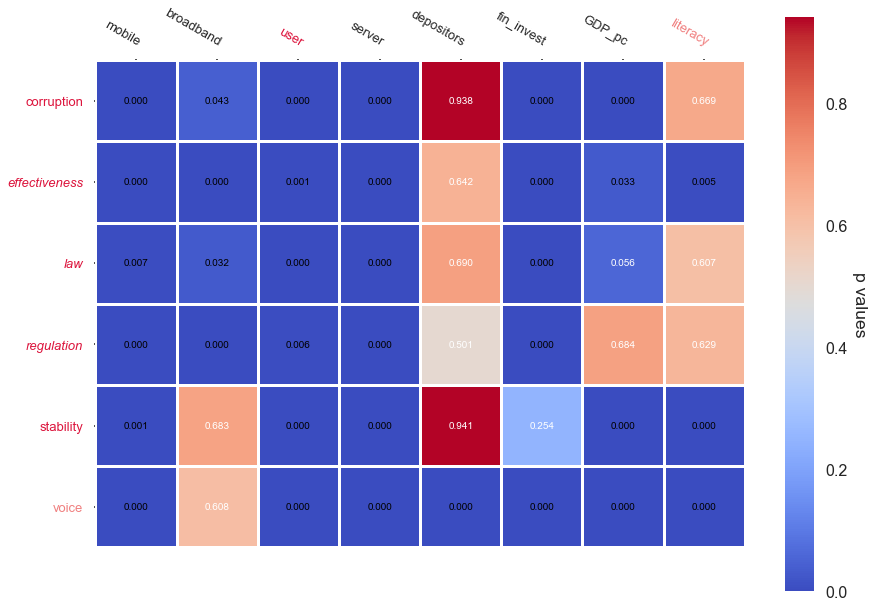

In [50]:
mpl.style.use('seaborn-poster')
fig, ax = plt.subplots()

im, cbar = heatmap(p_value, params, p_value.index.tolist(), p_value.columns.tolist(), ax=ax,
                   cmap="coolwarm", cbarlabel="p values")
texts = annotate_heatmap(im, valfmt="{x:.3f}", threshold = 0.05)

ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=13)


fig.tight_layout()

In the above heatmap, colors indicate the magnitude of p-values, with blue indicating lower p-values and red indicating higher p-values. Texts within each cell are the actual p-values. Using a 5% significance level, p-values in black indicate significance for the corresponding exogenous and endogenous variables whereas p-values in white indicate absence of significance. Even in the presence of control variables, most of the ICT development variables still turned out to have a statistically significant relationship with most governance scores, except fixed broadband prevalence for stability and voice. This finding can already corroborate, to some extent, that higher prevalence of mobile and fixed broadband subscriptions and secure servers is positively correlated with better governance results across all six dimensions.

One intriguing finding is that Internet users as a percentage of population is negatively correlated with all the endogenous variables, for which there is no obvious explanation. One control variable, literacy rate, is also negatively correlated to voice and accountability. One potential reason is that authoritarian regimes may tend to have more uniform and tightly-controlled education system, but it is out of the scope of this project to confirm the validity of this hypothesis.

Three endogenous variables, namely effectiveness, law and regulation are in italic in the heatmap. As we will show in the model diagnostics, regressions with these three variables are considered to be the most robust.

## Cross-sectional model diganostics

Given the fact that many ICT variables are significantly correlated to most govenance scores, we skip the overall model significance test (the F-test) and turn directly to R-squares of each regression. As the bar chart below shows, all six models account for a fair proportion of variations within endogenous variables, as the R-squares ranges from 0.35 for stability to 0.62 for effectiveness.

([0, 1, 2, 3, 4, 5], <a list of 6 Text xticklabel objects>)

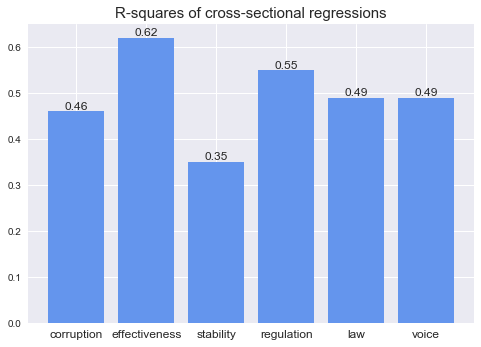

In [80]:
rsquared = pd.DataFrame()
for i in reg_results_cs.index.get_level_values('eng').unique():
    rsquared.loc[i,'rsquared']=reg_results_cs.loc[(i,'mobile'),'rsquared']
rsquared=rsquared.round(2)
    
fig, ax = plt.subplots()
ax.bar(rsquared.index, rsquared['rsquared'])
rect = ax.bar(rsquared.index, rsquared['rsquared'], color='cornflowerblue')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    i=0
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                str(height),
                ha='center', va='bottom',size=12)
        i+=1
        
autolabel(rect) 
ax.set_title('R-squares of cross-sectional regressions',size=15)
plt.xticks(rotation=0, size=12)

Another aspect to consider in model diagnostics is the residuals. While normally distributed residuals cannot completely guarantee the absence of any correlation between the residuals and exogenous variables, a non-normal distribution of the residuals may raise red flags for potential endogeneity. 

The histograms below show the distribution of residuals for all six regressions. The green vertical line shows the median of the distribution, and the red/blue verticle line indicates the mean. As the graphs show, residual distributions for corruption, stability and voice are somewhat skewed, whereas the residual distributions for effectiveness, law and regulation are closer to normal distribution dispite some outliers. This indicates that regression models for effectiveness, law and regulation are more likely to be robust.

Text(0.5, 1.0, 'voice')

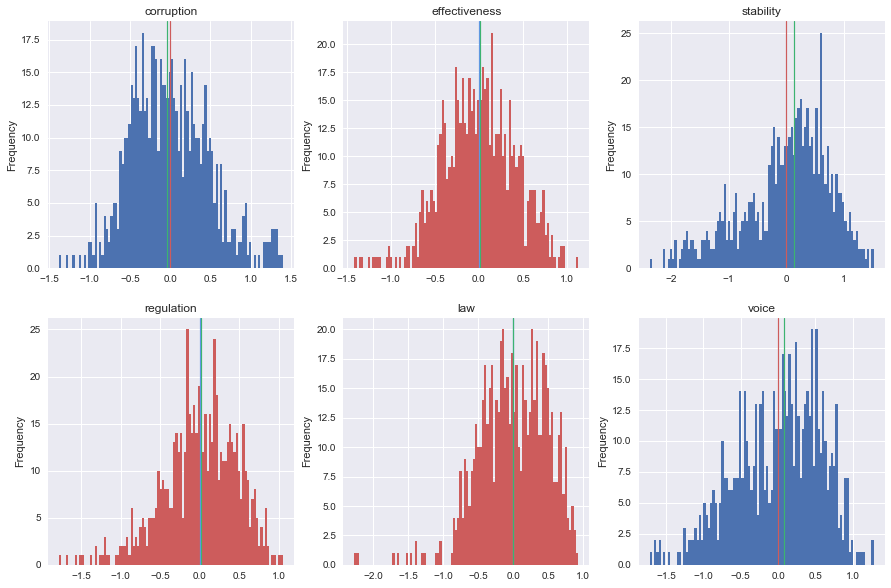

In [51]:
mpl.style.use('seaborn')
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)
fig.set_size_inches(15,10)

df['corruption_cserror'].plot.hist(bins=100,ax=ax1)
ax1.axvline(df['corruption_cserror'].mean(), color = 'indianred',lw=1.2)
ax1.axvline(df['corruption_cserror'].median(), color = 'mediumseagreen',lw=1.2)

df['effectiveness_cserror'].plot.hist(bins=100,ax=ax2, color='indianred')
ax2.axvline(df['effectiveness_cserror'].mean(), color = 'cornflowerblue',lw=1.2)
ax2.axvline(df['effectiveness_cserror'].median(), color = 'mediumseagreen',lw=1.2)

df['stability_cserror'].plot.hist(bins=100,ax=ax3)
ax3.axvline(df['stability_cserror'].mean(), color = 'indianred',lw=1.2)
ax3.axvline(df['stability_cserror'].median(), color = 'mediumseagreen',lw=1.2)

df['regulation_cserror'].plot.hist(bins=100,ax=ax4, color='indianred')
ax4.axvline(df['regulation_cserror'].mean(), color = 'cornflowerblue',lw=1.2)
ax4.axvline(df['regulation_cserror'].median(), color = 'mediumseagreen',lw=1.2)

df['law_cserror'].plot.hist(bins=100,ax=ax5, color='indianred')
ax5.axvline(df['law_cserror'].mean(), color = 'cornflowerblue',lw=1.2)
ax5.axvline(df['law_cserror'].median(), color = 'mediumseagreen',lw=1.2)

df['voice_cserror'].plot.hist(bins=100,ax=ax6)
ax6.axvline(df['voice_cserror'].mean(), color = 'indianred',lw=1.2)
ax6.axvline(df['voice_cserror'].median(), color = 'mediumseagreen',lw=1.2)


ax1.set_title('corruption')
ax2.set_title('effectiveness')
ax3.set_title('stability')
ax4.set_title('regulation')
ax5.set_title('law')
ax6.set_title('voice')

## Fixed-effect regressions

While pooled cross-sectional models show many significant relationships between ICT variables and governance indicators, fixed-effects models provides better control of country-specific characteristics and time trends that the cross-sectional models fail to account for because of limited number of control variables.

In [81]:
reg_results = pd.DataFrame(columns=['params','p_value'], index=index)
for eng in engs:
    y, X = dmatrices( eng + '~  broadband + mobile + user + server + depositors + fin_invest + GDP_pc + literacy', data=df, return_type='dataframe')
    mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
    res = mod.fit(cov_type='robust')

    df[eng+'_hat'] = res.fitted_values
    df[eng+'_error'] = df[eng] - df[eng+'_hat']

    for i in res.params.index[1:]:
        reg_results.loc[(eng,i),'params']=res.params.loc[i]
        reg_results.loc[(eng,i),'p_value']=res.pvalues.loc[i]
        reg_results.loc[(eng,i),'rsquared']=res.rsquared
        reg_results.loc[(eng,i),'f_stat']=res.f_statistic_robust.stat   

for i in reg_results.columns:
    reg_results[i]=pd.to_numeric(reg_results[i])

In [84]:
reg_sig = reg_results.loc[reg_results['p_value']<=0.05]
params = pd.pivot_table(reg_sig, values='params', index=['eng'], columns=['exog'])
params=params.fillna(0)
params = params[exogs]


p_value = pd.pivot_table(reg_results, values='p_value', index=['eng'], columns=['exog'])
p_value=p_value[exogs]

params=params.reindex(p_value.index.tolist())

In [85]:
params

exog,mobile,broadband,user,server,depositors,fin_invest,GDP_pc,literacy
eng,,,,,,,,
corruption,0.002326,0.000000,0.000000,0.034362,0.000000,0.00000,0.00000,0.000000
effectiveness,0.000000,0.000000,0.006072,0.044311,0.000000,0.00000,0.00000,0.000000
law,0.001171,0.000000,0.003171,0.033897,0.000000,0.00000,0.00000,0.000000
regulation,0.002917,0.000000,0.002688,0.039716,0.000000,0.00000,0.00000,0.007523
stability,0.000000,0.000000,0.000000,0.000000,0.000764,0.00000,0.00004,0.000000
voice,0.001774,-0.011668,0.000000,0.025823,0.000000,0.00349,0.00000,-0.007656


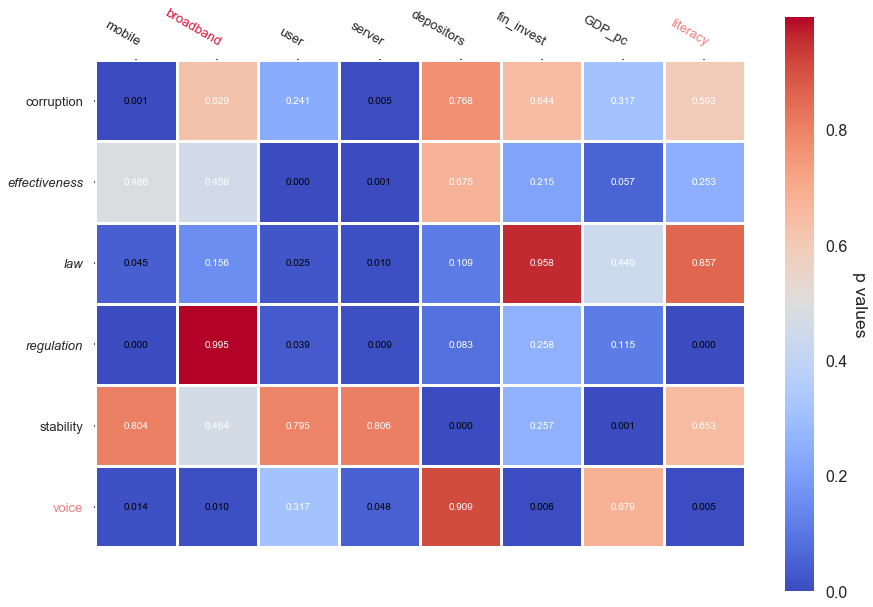

In [86]:
mpl.style.use('seaborn-poster')
fig, ax = plt.subplots()

im, cbar = heatmap(p_value, params, p_value.index.tolist(), p_value.columns.tolist(), ax=ax,
                   cmap="coolwarm", cbarlabel="p values")
texts = annotate_heatmap(im, valfmt="{x:.3f}", threshold = 0.05)

ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=13)


fig.tight_layout()


As the heatmap show, taking into account country and time trends takes away the significance of many ICT variables, indicating certain overestimated effects in the cross-sectional models. In particular, no ICT variable is significant for stability. This is unsurprising due to the fact that political stability and violence are often related to historical reasons largely unrelated to ICT, especially after controlling for income. For other governance dimensions, at least two ICT variables are significant in each individual regression.

## Fixed-effect regression model diagnostics

Similar to results from the cross-sectional regressions, regressions on effectiveness, law and regulation yield residual distributions that are close to normal, whereas other regressions have skewed residual distributions. However, the two models exhibit drastic differences in R-squares, as shown by the bar chart below.

Text(0.5, 1.0, 'voice')

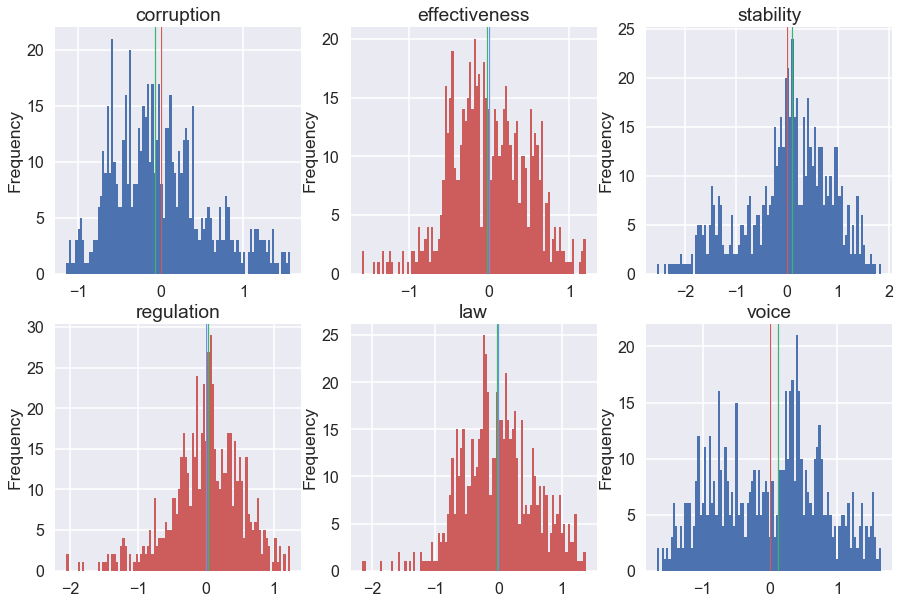

In [87]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)
fig.set_size_inches(15,10)

df['corruption_error'].plot.hist(bins=100,ax=ax1)
ax1.axvline(df['corruption_error'].mean(), color = 'indianred',lw=1.2)
ax1.axvline(df['corruption_error'].median(), color = 'mediumseagreen',lw=1.2)

df['effectiveness_error'].plot.hist(bins=100,ax=ax2, color='indianred')
ax2.axvline(df['effectiveness_error'].mean(), color = 'cornflowerblue',lw=1.2)
ax2.axvline(df['effectiveness_error'].median(), color = 'mediumseagreen',lw=1.2)

df['stability_error'].plot.hist(bins=100,ax=ax3)
ax3.axvline(df['stability_error'].mean(), color = 'indianred',lw=1.2)
ax3.axvline(df['stability_error'].median(), color = 'mediumseagreen',lw=1.2)

df['regulation_error'].plot.hist(bins=100,ax=ax4,color='indianred')
ax4.axvline(df['regulation_error'].mean(), color = 'cornflowerblue',lw=1.2)
ax4.axvline(df['regulation_error'].median(), color = 'mediumseagreen',lw=1.2)

df['law_error'].plot.hist(bins=100,ax=ax5, color='indianred')
ax5.axvline(df['law_error'].mean(), color = 'cornflowerblue',lw=1.2)
ax5.axvline(df['law_error'].median(), color = 'mediumseagreen',lw=1.2)

df['voice_error'].plot.hist(bins=100,ax=ax6)
ax6.axvline(df['voice_error'].mean(), color = 'indianred',lw=1.2)
ax6.axvline(df['voice_error'].median(), color = 'mediumseagreen',lw=1.2)



ax1.set_title('corruption')
ax2.set_title('effectiveness')
ax3.set_title('stability')
ax4.set_title('regulation')
ax5.set_title('law')
ax6.set_title('voice')

In [88]:
iterables = [['corruption', 'effectiveness', 'stability', 'regulation', 'law', 'voice'],
             ['rsquared_cs','rsquared_fe']]
index = pd.MultiIndex.from_product(iterables, names=['Endogenous', 'reg_type'])

In [89]:
rsquared = pd.DataFrame(index=index)
for i in reg_results.index.get_level_values('eng').unique():
    rsquared.loc[(i,'rsquared_cs'),'rsquared']=reg_results_cs.loc[(i,'mobile'),'rsquared']
    rsquared.loc[(i,'rsquared_fe'), 'rsquared']=reg_results.loc[(i,'mobile'),'rsquared']
rsquared=rsquared.reset_index()

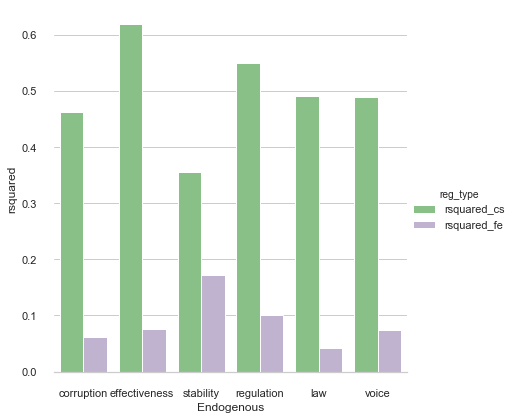

In [97]:
sns.set(style="whitegrid")
ax = sns.catplot(x='Endogenous', y='rsquared', hue='reg_type', data=rsquared,
                height=6, kind="bar", palette="Accent")
ax.despine(left=True)

Most of the fixed-effect regressions on the six governance dimensions have R-squares below 10%, which indicates that only a small proportion of within-country variations are explained by the variables explicitly expressed in the regression models. 

# Single variable zoom-in

In [180]:
var_dict0 = {'mobile':'corruption'}
var_dict1 = {'user': 'effectiveness'}
var_dict2 = {'mobile':'regulation'}
var_dict3 = {'corruption':'mobile'}
var_dict4 = {'effectiveness': 'user'}
var_dict5 = {'regulation':'mobile'}

In [189]:
def find_high_growth(variable_dictionary):
    for i in variable_dictionary:
        growth=pd.DataFrame()
        
        # Generate growth of the first variable
        exog_column_num = df.columns.tolist().index(i)
        for e in df.index.get_level_values('country_name'):
            growth.loc[e,'growth']=df.loc[[e]].iloc[-1,exog_column_num]-df.loc[[e]].iloc[0,exog_column_num]
            growth.loc[e,'inc_group']=df.loc[[e]].iloc[-1,10]   
        
        # Find the 50 top ranking countries for the growth of the first variable 
        hgrowth = growth.sort_values(by='growth',ascending = False).index.tolist()[0:50]
        
        # Find change of the second variable
        eng_column_num = df.columns.tolist().index(variable_dictionary[i])
        for p in df.index.get_level_values('country_name'):
            governance_change=df.loc[[p]].iloc[-1,eng_column_num]- df.loc[[p]].iloc[0,eng_column_num]
            growth.loc[p,'governance_change']=governance_change
            
        # Generate a shortened dataframe with only the 50 top ranking countries in 1st variable growth    
        high_growth = growth.loc[growth.index.isin(hgrowth)].sort_values(by='growth',ascending=False)
        
        # Convert the 1st and 2nd variable changes into within-sample percentiles for countries in the short datafram
        for h in high_growth.index:
            high_growth.loc[h,'governance_ranking']=stats.percentileofscore(growth['governance_change'],growth.loc[h,'governance_change'])
            high_growth.loc[h,'ICT_ranking']=stats.percentileofscore(growth['growth'],growth.loc[h,'growth'])
            
        return high_growth

Text(0, 0.5, 'mobile growth')

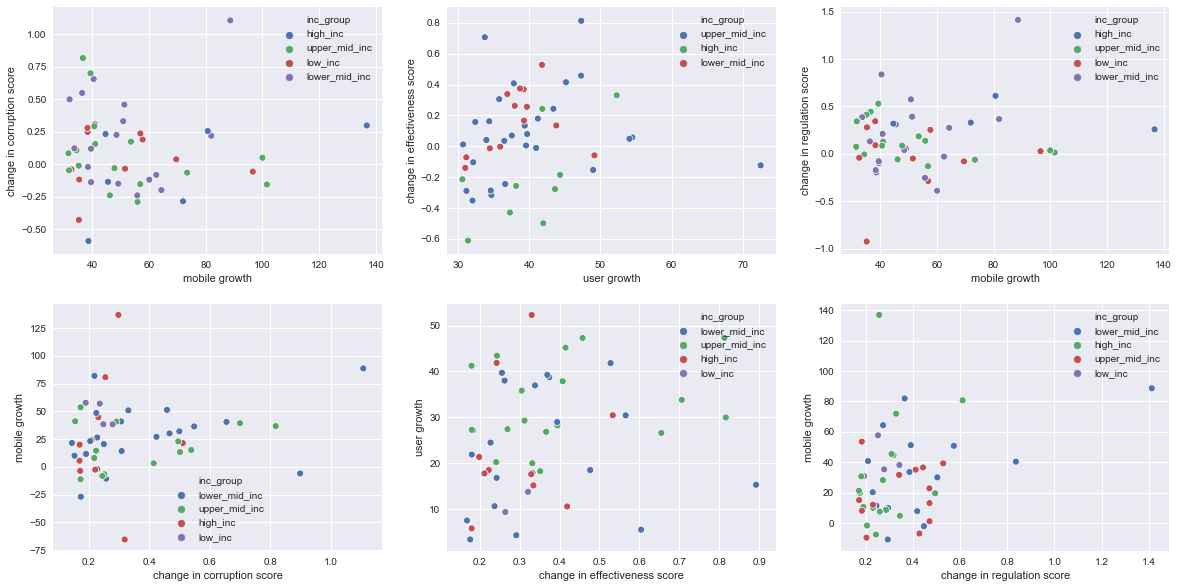

In [188]:
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(20,10)
sns.scatterplot(x='growth', y='governance_change',
           hue="inc_group", data=find_high_growth(var_dict0),  ax=axes[0,0])
sns.scatterplot(x='growth', y='governance_change',
           hue="inc_group", data=find_high_growth(var_dict1),  ax=axes[0,1])
sns.scatterplot(x='growth', y='governance_change',
           hue="inc_group", data=find_high_growth(var_dict2),  ax=axes[0,2])
sns.scatterplot(x='growth', y='governance_change',
           hue="inc_group", data=find_high_growth(var_dict3),  ax=axes[1,0])
sns.scatterplot(x='growth', y='governance_change',
           hue="inc_group", data=find_high_growth(var_dict4),  ax=axes[1,1])
sns.scatterplot(x='growth', y='governance_change',
           hue="inc_group", data=find_high_growth(var_dict5),  ax=axes[1,2])

axes[0,0].set_xlabel('mobile growth')
axes[0,0].set_ylabel('change in corruption score')
axes[0,1].set_xlabel('user growth')
axes[0,1].set_ylabel('change in effectiveness score')
axes[0,2].set_xlabel('mobile growth')
axes[0,2].set_ylabel('change in regulation score')
axes[1,0].set_xlabel('change in corruption score')
axes[1,0].set_ylabel('mobile growth')
axes[1,1].set_xlabel('change in effectiveness score')
axes[1,1].set_ylabel('user growth')
axes[1,2].set_xlabel('change in regulation score')
axes[1,2].set_ylabel('mobile growth')


Text(0, 0.5, 'mobile growth percentile rank')

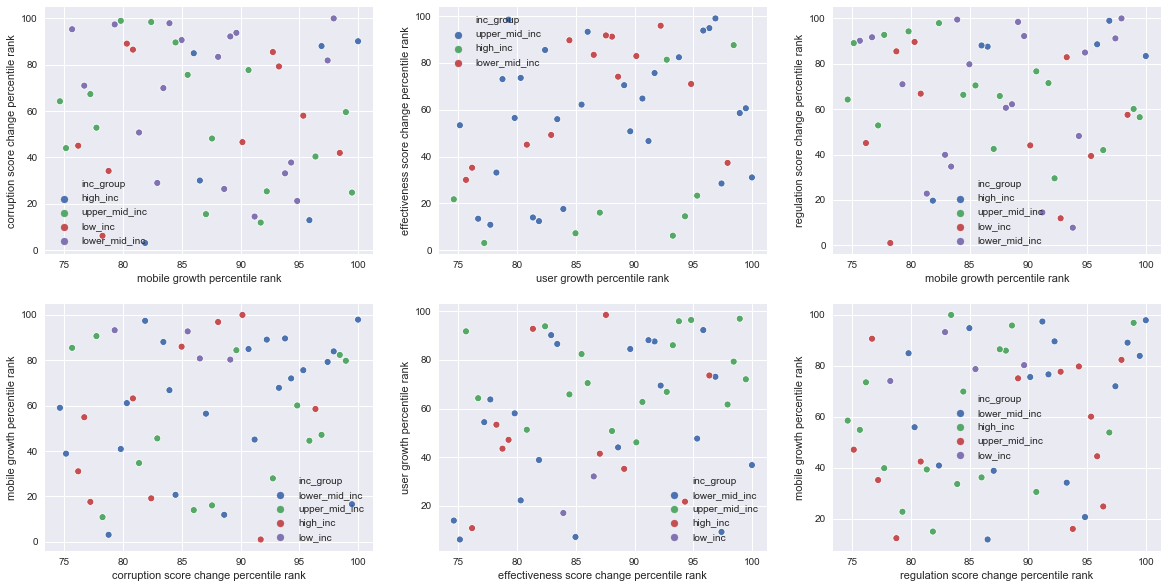

In [190]:
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(20,10)
sns.scatterplot(x='ICT_ranking', y='governance_ranking',
           hue="inc_group", data=find_high_growth(var_dict0),  ax=axes[0,0])
sns.scatterplot(x='ICT_ranking', y='governance_ranking',
           hue="inc_group", data=find_high_growth(var_dict1),  ax=axes[0,1])
sns.scatterplot(x='ICT_ranking', y='governance_ranking',
           hue="inc_group", data=find_high_growth(var_dict2),  ax=axes[0,2])
sns.scatterplot(x='ICT_ranking', y='governance_ranking',
           hue="inc_group", data=find_high_growth(var_dict3),  ax=axes[1,0])
sns.scatterplot(x='ICT_ranking', y='governance_ranking',
           hue="inc_group", data=find_high_growth(var_dict4),  ax=axes[1,1])
sns.scatterplot(x='ICT_ranking', y='governance_ranking',
           hue="inc_group", data=find_high_growth(var_dict5),  ax=axes[1,2])

axes[0,0].set_xlabel('mobile growth percentile rank')
axes[0,0].set_ylabel('corruption score change percentile rank')
axes[0,1].set_xlabel('user growth percentile rank')
axes[0,1].set_ylabel('effectiveness score change percentile rank')
axes[0,2].set_xlabel('mobile growth percentile rank')
axes[0,2].set_ylabel('regulation score change percentile rank')
axes[1,0].set_xlabel('corruption score change percentile rank')
axes[1,0].set_ylabel('mobile growth percentile rank')
axes[1,1].set_xlabel('effectiveness score change percentile rank')
axes[1,1].set_ylabel('user growth percentile rank')
axes[1,2].set_xlabel('regulation score change percentile rank')
axes[1,2].set_ylabel('mobile growth percentile rank')